In [1]:
#import libraries for analysis
#pandas for dataframes
import pandas as pd
#datetime for converting numerics to datetime format
import datetime as dt
#yahoo finance dividend adjusted closes for prototyping
import yfinance as yf
#statsmodels for ols regressions
import statsmodels.api as sm
#convert dataframes to numpy format because sklearn does not take dataframes well
import numpy as np
from finance_byu.fama_macbeth import fama_macbeth, fama_macbeth_parallel, fm_summary, fama_macbeth_numba


#this is the list of classifiers from sklearn that are available for analysis. "kitchen sink" approach
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [2]:
#this is a base class which we use put our parameters. All the other classes inherit from this
class BacktestParameters:
    
    def __init__(self, stk_symbols, start, end, lookback_alpha, lev):
        #the stock symbols
        self.stk_symbols = stk_symbols
        #start of the data series
        self.start = start
        #end of the data series
        self.end = end
        #index security
        #the lookback period for calculating alpha and idiosyncratic volatility
        self.lookback = lookback_alpha
        #leverage to apply to the strategy
        self.lev = lev

#class for pulling the yahoo finance data and cleaning so we have monthly data
class Data(BacktestParameters):
    
    def __init__(self, bp):
        #inherit from the base class
        self.stk_symbols = bp.stk_symbols
        self.start = bp.start
        self.end = bp.end
        self.lookback = bp.lookback
        
    #method for get getting the adjusted closes from yahoo
    def get_data(self):
        close = pd.DataFrame()

        for i in self.stk_symbols:

            df = yf.download(i, start=self.start, end=self.end, progress=False)
            df = pd.DataFrame(df['Adj Close'])
            df.columns = [i]
            if close.empty:
                close = df.copy()
            else:
                close = pd.concat([close, df], axis = 1)

        #get the daily returns
        returns = close.pct_change()[1:]

        print(returns.head())
        
        return returns
    
    #converts the daily returns to a geometric return for the month
    def convert_monthly(self, returns):
        returns = returns.resample('M').agg(lambda x: (x + 1).prod(skipna = True) - 1)
        
        #the geometric returns convert null values at the beginning of the time series to zeros.
        #this converts the data back to null values so we dont allocate to data that does not exist 
        for i in returns.columns:
            found = False
            for date, row in returns.loc[:,i].iteritems():
                if row == 0.0 and ~found:
                    returns.loc[date, i] = np.nan
                else:
                    found = True
        print(returns)
        return returns
    
    
    #this method takes a dataframe and converts to a binary output based off the center variable
    def get_binary(self, df_input, center = 0.0):
        
        binary_alpha = df_input.astype(float)
        #greater than the center var is a 1
        binary_alpha[binary_alpha >= center] = 1.0
        #less than the center var is a 0.0
        binary_alpha[binary_alpha < center] = 0.0
        
        return binary_alpha
        
#class for the backtesting of our classification
class Backtest():
    #instantiate with the backtest parameters with the returns data
    def __init__(self, bp, returns, mode):
        #the stock symbols
        self.stk_symbols = bp.stk_symbols
        #start of the data series
        self.start = bp.start
        #end of the data series
        self.end = bp.end
        #index security
        #the lookback period for calculating alpha
        self.lookback = bp.lookback
        self.returns = returns
        self.mode = mode
        
        
    def check_new_factor(self, backtest, factor_model, index_symbol):
        
        new_factor = pd.DataFrame(backtest.mean(axis = 1))
        new_factor.columns = ['portfolio']

        Y = factor_model.loc[new_factor.index, index_symbol]
        Y = pd.DataFrame(Y)
        X = factor_model.loc[new_factor.index]
        X = pd.concat([new_factor, X], axis = 1)
        X['intercept'] = 1.0
        X = X.shift(1).dropna(axis = 0)
        Y = Y.iloc[1:]
        model = sm.OLS(Y,X, missing = 'drop')
        results = model.fit()
        print(results.summary())  
        betas = results.params

        #2nd step. regress all asset returns for a fixed time period against the estimated betas to determine the risk premium for each factor.

        prems = {}
        for count, row in X.iterrows():
            y = Y.loc[count]
            y = pd.DataFrame(y).T
            x = pd.DataFrame(row).T
            model = sm.OLS(y,x, missing = 'drop')
            results = model.fit()
            prems[count] = results.params

        print("Factor Loadings")
        prems = pd.DataFrame(prems).T
        print(prems.head(20))
        expected_prems = prems.mean()
        t_stats = expected_prems / (prems.std()/ np.sqrt(len(prems.index)))
        print("expected premiums for each risk factor")
        print(expected_prems)
        print("t-stats for each risk factor")
        print(t_stats)
  
            
    """
    this method gets the equal weight portfolio of our strategy and compares to the factor model of choice. 
    Takes the backtest dataframe which is the actual returns of the strategy.
    """
    
    def factor_results(self, backtest, factor_model):
        
        port= pd.DataFrame(backtest.mean(axis = 1))
        port.columns = ['portfolio']

        #1st step. run the regression of factors on the portfolio
        Y = pd.DataFrame(port)
        X = factor_model.loc[port.index]
        X['intercept'] = 1.0
        model = sm.OLS(Y,X,missing = 'drop')
        results = model.fit()
        print(results.summary())  
        betas = results.params

        #2nd step. regress all asset returns for a fixed time period against the estimated betas to determine the risk premium for each factor.

        prems = {}
        for count, row in X.iterrows():
            try:
                y = Y.loc[count,:]
                y = pd.DataFrame(y).T
                x = pd.DataFrame(row).T
                model = sm.OLS(y,x, missing = 'drop')
                results = model.fit()
                prems[count] = results.params
            except:
                #this is to deal nans in the y and x
                pass

        print("Factor Loadings")
        prems = pd.DataFrame(prems).T
        print(prems.head(20))
        expected_prems = prems.mean()
        t_stats = expected_prems / (prems.std()/ np.sqrt(len(prems.index)))
        print("expected premiums for each risk factor")
        print(expected_prems)
        print("t-stats for each risk factor")
        print(t_stats)

 
    
    #this method is for actually running the backtest and getting the portfolios returns and allocations
    def run_backtest(self, input_classifiers, lookback_backtest, inputs, outputs,  ensemble = 'no', trade_type = 'both'):
        
        """
        the input_classifiers is a string of which classifier to use. This can be an array for multiple classifiers
        lookback_test is an integer for the time length to use for the feature set to use for the analysis
        inputs is a dataframe of the feature set
        output is a dataframe of the output variable to train our feature set on. This is returns across the assets
        for analysis
        ensemble is a yes or not string for whether to take an array of classifiers and a voting method to get 
        asset returns
        trade_type: this determines if the portfolio is long only, short only, or both
        """
        
        #gets the lowercase sting of the ensemble input.
        ensemble = ensemble.lower()
        
        #if we input multiple classifiers this converts the system to an ensemble output. You can only input one
        #classifier at a time or an ensemble system
        if ensemble == 'no' and len(input_classifiers) > 1:
            print("For non emsemble systems the amount of input classifiers are restricted to one. The following backtest will be changed to a ensemble system")
            ensemble = 'yes'
        
        
        #dictionary to convert the classifiers string inputs to actual sklearn classifiers
        classifiers = {"Nearest Neighbors" : KNeighborsClassifier(3), \
                       "Linear SVM" : SVC(),\
                        "RBF SVM": SVC(gamma=2, C=1), \
                        "Gaussian Process" : GaussianProcessClassifier(1.0 * RBF(1.0)), \
                        "Decision Tree" : DecisionTreeClassifier(max_depth=5), \
                        "Random Forest" : RandomForestClassifier(max_depth=3, n_estimators=2, max_features=1, random_state=1), \
                        "Neural Net": MLPClassifier(solver='adam', learning_rate = 'adaptive', alpha=1e-3, hidden_layer_sizes=(5),max_iter= 10000, random_state=1), \
                        "AdaBoost": AdaBoostClassifier(), \
                        "Naive Bayes": GaussianNB(), \
                        "QDA": QuadraticDiscriminantAnalysis()}

        #create a blank dataframe for our backtest data
        ml_backtest = pd.DataFrame()
        ml_weights = pd.DataFrame()

        #iterate through each symbol and run the backtest on the symbol
        for ticker in inputs.keys():

            count = 0

            #instantiate a dataframe for our backtest outputs for one ticker. we can only run the backtest on the index of 
            #the inputs. we remove the lookback period for analysis
            
            backtest = pd.DataFrame()
            weights = pd.DataFrame()
            
            #iterate through the inputs
            for ix, row in inputs[ticker].iterrows(): 

                if count >= lookback_backtest:
                    #the analysis df does not include the current row
                    analysis = inputs[ticker][count-lookback_backtest:count]

                    #the y var is the binary returns of the ticker
                    y = outputs[ticker].loc[analysis.index][1:].copy()
                    #the x var is the returns for the ticker on the analysis index lagged by 1
                    x = inputs[ticker].loc[analysis.index].shift(1)[1:].copy()
                    #test x represents the yesterdays x value, this is for the outsample prediction on y
                    test_x = inputs[ticker].loc[analysis.index].tail(1)
                    #to run a single classifier
                    if ensemble == 'no':
                        for name in input_classifiers:
                            #fit the classifier to the inputs
                            clf = classifiers[name]
                            clf.fit(x.to_numpy(), y.values.ravel())
                            #make a prediction on the input features 
                            predict = clf.predict(x.to_numpy())
                            predict = pd.DataFrame(data = predict, index = y.index, columns = ['predict'])
                            #mse = np.sum((y.values - predict.values.T)**2)
                            #predict the last observation in the feature set to predict y tomorrow
                            outsample = clf.predict(test_x.to_numpy())[0]
                        #if the classifier is one. we long the security times the leverage
                        if trade_type == 'both':
                            if outsample == 1.0:
                                backtest.loc[ix, ticker]  = returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = 1.0
                            #if the classifier is 0 we can choose to short the security or be long only
                            else:
                                backtest.loc[ix, ticker]  = -returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = -1.0
                                
                        elif trade_type == 'short':
                            if outsample == 1.0:
                                backtest.loc[ix, ticker]  = np.nan
                                weights.loc[ix, ticker] = np.nan
                            #if the classifier is 0 we can choose to short the security or be long only
                            else:
                                backtest.loc[ix, ticker]  = -returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = -1.0
                                
                        elif trade_type == 'long':
                            if outsample == 1.0:
                                backtest.loc[ix, ticker]  = returns.loc[ix, ticker] * lev
                                weights.loc[ix, ticker] = 1.0
                            #if the classifier is 0 we can choose to short the security or be long only
                            else:
                                backtest.loc[ix, ticker]  = np.nan
                                weights.loc[ix, ticker] = np.nan
                        else:
                            backtest.loc[ix, ticker]  = np.nan
                            weights.loc[ix, ticker] = np.nan
                            
                    #to do the voting method on all the classifiers
                    else:
                        all_outsample = []
                        for name in input_classifiers:
                            clf = classifiers[name]
                            clf.fit(x.to_numpy(), y.values.ravel())
                            predict = clf.predict(x.to_numpy())
                            predict = pd.DataFrame(data = predict, index = y.index, columns = ['predict'])
                            #mse = np.sum((y.values - predict.values.T)**2)
                            outsample = clf.predict(test_x.to_numpy())[0]
                            all_outsample.append(outsample)
                        #take the average of the classfier outputs 
                        avg = sum(all_outsample) / len(all_outsample)  
                        #if greater than .5, then go long the security. this paramber could be optimized
                        if avg >= 0.5:
                            backtest.loc[ix, ticker]  = returns.loc[ix, ticker] * lev
                            weights.loc[ix, ticker] = 1.0
                            
                        #if the classifier is 0 we can choose to short the security or be long only
                        else:
                            backtest.loc[ix, ticker]  = -returns.loc[ix, ticker] * lev
                            weights.loc[ix, ticker] = -1.0
                count = count + 1
                
            #concatentate the backtest for one ticker with the rest to give the portfolio. 
            if ml_backtest.empty:
                ml_backtest = backtest.copy()
                ml_weights = weights.copy()
            else:
                ml_backtest = pd.concat([ml_backtest, backtest], axis = 1)
                ml_weights = pd.concat([ml_weights, weights], axis = 1)

        #return a dataframe of all the backtests on input tickers
        return ml_backtest, ml_weights
        
        
        

In [4]:
crsp_data= pd.read_csv('/home/janko/Desktop/crsp_data.csv')
print(crsp_data.head(5))

/home/janko/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   PERMNO        date  SHRCD  EXCHCD SICCD    NCUSIP TICKER  \
0   10000  12/31/1985    NaN     NaN   NaN       NaN    NaN   
1   10000  01/31/1986   10.0     3.0  3990  68391610  OMFGA   
2   10000  02/28/1986   10.0     3.0  3990  68391610  OMFGA   
3   10000  03/31/1986   10.0     3.0  3990  68391610  OMFGA   
4   10000  04/30/1986   10.0     3.0  3990  68391610  OMFGA   

                      COMNAM SHRCLS  PERMCO     CUSIP     PRC        RET  \
0                        NaN    NaN    7952  68391610     NaN        NaN   
1  OPTIMUM MANUFACTURING INC      A    7952  68391610 -4.3750          C   
2  OPTIMUM MANUFACTURING INC      A    7952  68391610 -3.2500  -0.257143   
3  OPTIMUM MANUFACTURING INC      A    7952  68391610 -4.4375   0.365385   
4  OPTIMUM MANUFACTURING INC      A    7952  68391610 -4.0000  -0.098592   

   SHROUT    vwretd    vwretx    ewretd    ewretx  
0     NaN  0.043061  0.040080  0.028021  0.026355  
1  3680.0  0.009829  0.008006  0.044071  0.043082  
2  3680.

In [5]:
ret_data= pd.pivot_table(crsp_data, values = 'RET', index = 'date', columns= 'PERMNO')
print(ret_data.head(5))

DataError: No numeric types to aggregate

In [28]:
industry = pd.read_csv('48_Industry_Portfolios.csv', index_col = 0)
industry.index = pd.to_datetime(industry.index, format= '%Y%m')
industry[industry <= -99.] = np.nan
industry = industry / 100.0

ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', index_col = 0)
ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
ff_factors = ff_factors / 100.0

factor_model = ff_factors.copy().dropna(axis = 0, how = 'any')
rf = factor_model[['RF']]
factor_model = factor_model[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

industry = industry.loc[rf.index,:]
index_symbol = 'Mkt-RF'

print(ff_factors.head(5))

print(industry.head(5))

            Mkt-RF     SMB     HML     RMW     CMA      RF
1963-07-01 -0.0039 -0.0047 -0.0083  0.0066 -0.0115  0.0027
1963-08-01  0.0507 -0.0079  0.0167  0.0040 -0.0040  0.0025
1963-09-01 -0.0157 -0.0048  0.0018 -0.0076  0.0024  0.0027
1963-10-01  0.0253 -0.0129 -0.0010  0.0275 -0.0224  0.0029
1963-11-01 -0.0085 -0.0084  0.0171 -0.0045  0.0222  0.0027
             Agric   Food    Soda    Beer    Smoke   Toys    Fun     Books  \
1963-07-01  0.0304 -0.0046  0.0257 -0.0219 -0.0254 -0.0507 -0.0070 -0.0007   
1963-08-01 -0.0032  0.0473  0.0550  0.0214  0.0715  0.0503  0.0784  0.0528   
1963-09-01 -0.0194 -0.0153 -0.0090  0.0123 -0.0423 -0.0515 -0.0226  0.0298   
1963-10-01 -0.0013  0.0269  0.0110 -0.0128  0.0578  0.1566  0.0196 -0.0199   
1963-11-01 -0.0306 -0.0039 -0.0058 -0.0072 -0.0563 -0.0083 -0.0397 -0.0062   

             Hshld   Clths  ...   Boxes   Trans   Whlsl   Rtail   Meals  \
1963-07-01 -0.0015 -0.0067  ...  0.0042 -0.0253  0.0004 -0.0106 -0.0421   
1963-08-01  0.0622  0.0483 

In [6]:
#start date for data
start = '2004-01-01'
#end date for data
end = '2020-01-01'

#the lookback for alpha feature
lookback = 60
#control the leverage
lev = 1.
stk_symbols  = factor_model.columns
returns = factor_model.copy()


#set the backtest parameters
bp = BacktestParameters(stk_symbols, start, end, lookback, lev  )
bt = Backtest(bp, returns, mode = 'insample')
d = Data(bp)



In [7]:
#initialize the alpha dataframe
df_alpha = returns[lookback:].copy()
#initialize the idiosyncratic volatility as well
idiosyncratic_vol = returns[lookback:].copy()

count = 0
#iterate through the monthly data. At each point in time we find the insample alpha and idiosyncratic vol
for ix, row in returns.iterrows(): 
    #check to make sure we have at least the lookback for analysis
    if count >= lookback:
        """
        note that python will not return the last part of the index. We want to by inclusive of this
        since this is an insample measure
        """
        analysis = returns[count-lookback:count]

        for ticker in returns.columns:
                #the dependent variable is our security and index var is the independent var
            try:
                y = pd.concat([analysis[ticker], rf.loc[analysis.index]], axis = 1)
                y = pd.DataFrame(y[ticker] - y[rf.columns[0]], columns = [ticker])
                # the index is your independent variable
                x = factor_model.loc[analysis.index].drop(ticker, axis = 1)
                #add a constant so we can get the alpha
                x = sm.add_constant(x)
                x = x.shift(1)
                
                #use simple ols
                mod = sm.OLS(y, x, missing='drop')
                res = mod.fit()
                #get the alpha
                alpha = res.params['const']
                #add the results to the alpha dataframe for analysis later
                df_alpha.loc[ix, ticker] = alpha
                #the line below is in case I want to analyze a simple difference 
                #df_alpha.loc[ix, ticker] = (analysis[ticker] - analysis[index_security ]).mean()
                #find the idiosyncratic volatility. Simply the residual squared. Note this is monthly
                idiosyncratic_vol.loc[ix, ticker] = res.resid.std()
            except:
                #if we have missing data we populate our analysis dataframe with null values 
                df_alpha.loc[ix, ticker] = np.nan
                idiosyncratic_vol.loc[ix, ticker] = np.nan
    #iterate to the next point in our data
    count = count + 1

#notice that I populated the alpha and idiosyncratic volatility with the full returns dataframe. 
#these two lines remove the lookback period for clean reading
df_alpha = df_alpha.dropna(axis = 0, how = 'all')
df_alpha = df_alpha.shift(1).dropna()
idiosyncratic_vol = idiosyncratic_vol.dropna(axis = 0, how = 'all')
binary_alpha = d.get_binary(df_alpha)

print(df_alpha.head(5))
print(idiosyncratic_vol.head(5))

              Mkt-RF       SMB       HML       RMW       CMA
1968-08-01  0.004686  0.006016 -0.000766 -0.002048 -0.006084
1968-09-01  0.003146  0.006134 -0.000267 -0.002788 -0.005145
1968-10-01  0.003727  0.006555 -0.000347 -0.002577 -0.005342
1968-11-01  0.003766  0.007209 -0.000303 -0.003457 -0.004763
1968-12-01  0.004546  0.007290 -0.000566 -0.003387 -0.004722
              Mkt-RF       SMB       HML       RMW       CMA
1968-07-01  0.029955  0.027251  0.017452  0.014173  0.019689
1968-08-01  0.029701  0.027173  0.018432  0.014811  0.020400
1968-09-01  0.029452  0.027096  0.018422  0.014703  0.020372
1968-10-01  0.029710  0.027022  0.018420  0.014432  0.020215
1968-11-01  0.029435  0.026727  0.018434  0.014492  0.020312


In [8]:
#the next few lines are a variety of feature to use

#get the rolling means of returns as a momentum feature. Subtract the last month's return
#12 month momentum factor
rolling_mean_12 = ((returns.rolling(window = 12).mean() - returns.rolling(window = 1).mean()) )[12:]
#6 month momentum factor
rolling_mean_6 = ((returns.rolling(window = 6).mean() - returns.rolling(window = 1).mean()) )[6:]

rolling_std_12 = (returns.rolling(window = 12).std() )[12:]

#convert the momentum factor a binary variable. The center is optimized to increase strategy sharpe
#turns the momentum factor to a 1 if the mean average return over past 12 months is over 15%/12
binary_mean_12 = d.get_binary(rolling_mean_12, center = 0.0/12)
binary_mean_6 = d.get_binary(rolling_mean_6, center = 0.0/12)
#convert the output feature to a binary variable for training the classifiers
binary_returns = d.get_binary(returns, center = 0.0/12)

#creates a dictionary of different features for analysis based on ticker keys
feature_list = [binary_alpha]

feature_set = {}

for i in feature_list:
    i = i.dropna(axis = 0, how = 'all')
    for j in i.columns:
        if j not in feature_set.keys():
            i[j].rename('0', inplace = True)
            feature_set[j] = pd.DataFrame(i[j].copy())
        else:
            i[j].rename(str(len(feature_set[j].columns)), inplace = True)
            feature_set[j] = pd.concat([feature_set[j], i[j].copy()], axis = 1).dropna(axis = 0, how = 'any')
        #remove rows where we do not have features for the whole portfolio.
        feature_set[j].dropna(axis = 0, how = 'any', inplace = True)

# KNN 

In [9]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'both')

In [10]:
bt.factor_results(backtest, factor_model)

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.087
Date:                Thu, 05 Nov 2020   Prob (F-statistic):              0.366
Time:                        11:57:11   Log-Likelihood:                 1674.2
No. Observations:                 613   AIC:                            -3336.
Df Residuals:                     607   BIC:                            -3310.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0272      0.016      1.707      0.0

<AxesSubplot:>

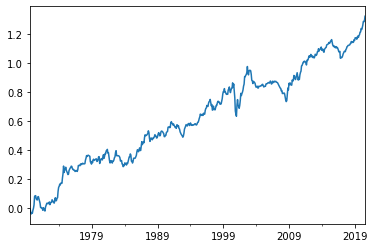

In [11]:
backtest.mean(axis = 1).cumsum().plot()

### Long only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     58.30
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           1.78e-49
Time:                        11:57:55   Log-Likelihood:                 1654.0
No. Observations:                 608   AIC:                            -3296.
Df Residuals:                     602   BIC:                            -3269.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.1922      0.016     11.927      0.0

<AxesSubplot:>

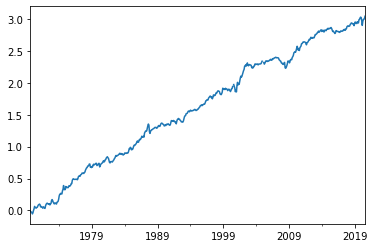

In [12]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'long')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Short only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     53.24
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           2.01e-45
Time:                        11:58:34   Log-Likelihood:                 1484.6
No. Observations:                 582   AIC:                            -2957.
Df Residuals:                     576   BIC:                            -2931.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.1816      0.020     -9.225      0.0

<AxesSubplot:>

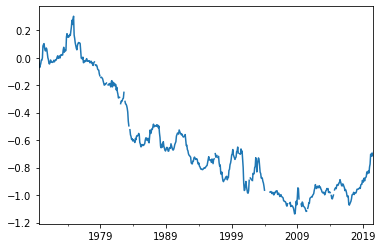

In [13]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'short')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

# Neural Net

In [14]:
backtest, weights = bt.run_backtest(input_classifiers= ["Neural Net"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no')

In [15]:
backtest.mean(axis = 1)

1969-08-01   -0.00564
1969-09-01   -0.00974
1969-10-01   -0.02832
1969-11-01    0.01368
1969-12-01    0.00748
               ...   
2020-04-01    0.03854
2020-05-01    0.03288
2020-06-01    0.01262
2020-07-01    0.00720
2020-08-01    0.02510
Length: 613, dtype: float64

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     15.99
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           8.16e-15
Time:                        12:12:21   Log-Likelihood:                 1702.1
No. Observations:                 613   AIC:                            -3392.
Df Residuals:                     607   BIC:                            -3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0482      0.015      3.171      0.0

<AxesSubplot:>

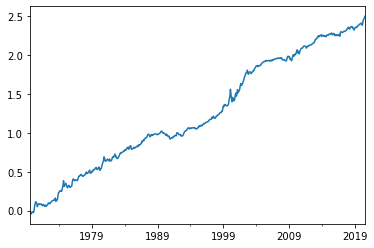

In [16]:
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

In [17]:
factor_model.mean(axis = 1).mean() / factor_model.mean(axis = 1).std()
backtest.mean(axis = 1).mean() / backtest.mean(axis = 1).std()

0.2545487942141256

### Long only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     101.8
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           6.59e-78
Time:                        12:26:24   Log-Likelihood:                 1851.6
No. Observations:                 613   AIC:                            -3691.
Df Residuals:                     607   BIC:                            -3665.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.1488      0.012     12.482      0.0

<AxesSubplot:>

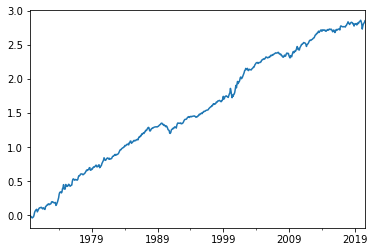

In [18]:
backtest, weights = bt.run_backtest(input_classifiers= ["Neural Net"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'long')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Short only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     41.10
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           5.14e-35
Time:                        12:36:49   Log-Likelihood:                 1039.7
No. Observations:                 471   AIC:                            -2067.
Df Residuals:                     465   BIC:                            -2042.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.3283      0.030    -10.877      0.0

<AxesSubplot:>

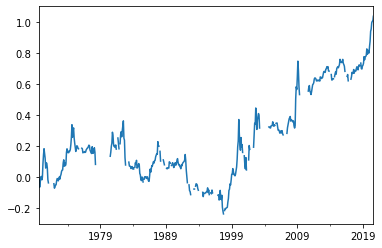

In [19]:
backtest, weights = bt.run_backtest(input_classifiers= ["Neural Net"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'short')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

# Random Forest

In [20]:
backtest, weights = bt.run_backtest(input_classifiers= ["Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no')

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     8.168
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           1.78e-07
Time:                        12:37:27   Log-Likelihood:                 1630.4
No. Observations:                 613   AIC:                            -3249.
Df Residuals:                     607   BIC:                            -3222.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.0099      0.017     -0.580      0.5

<AxesSubplot:>

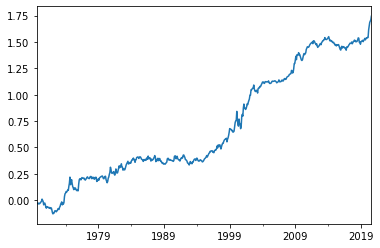

In [21]:
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Long Only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     50.06
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           2.43e-43
Time:                        12:38:07   Log-Likelihood:                 1587.9
No. Observations:                 605   AIC:                            -3164.
Df Residuals:                     599   BIC:                            -3137.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.1568      0.018      8.794      0.0

<AxesSubplot:>

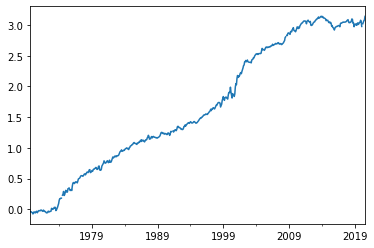

In [22]:
backtest, weights = bt.run_backtest(input_classifiers= ["Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'long')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

### Short Only

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     50.07
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           3.53e-43
Time:                        12:38:44   Log-Likelihood:                 1468.5
No. Observations:                 591   AIC:                            -2925.
Df Residuals:                     585   BIC:                            -2899.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -0.2451      0.021    -11.628      0.0

<AxesSubplot:>

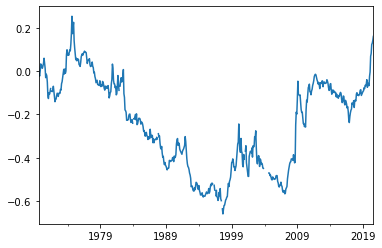

In [23]:
backtest, weights = bt.run_backtest(input_classifiers= ["Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'no', trade_type = 'short')
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

# Ensemble System

In [24]:
backtest, weights = bt.run_backtest(input_classifiers= ["Nearest Neighbors", "Random Forest"], lookback_backtest = 12, inputs = feature_set, outputs = binary_returns,  ensemble = 'yes')

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     18.51
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           3.94e-17
Time:                        12:39:37   Log-Likelihood:                 1749.3
No. Observations:                 613   AIC:                            -3487.
Df Residuals:                     607   BIC:                            -3460.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0778      0.014      5.525      0.0

<AxesSubplot:>

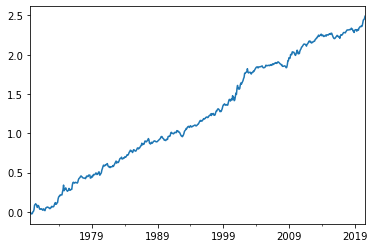

In [25]:
bt.factor_results(backtest, factor_model)
backtest.mean(axis = 1).cumsum().plot()

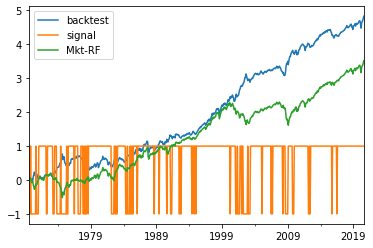

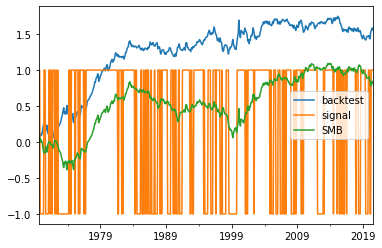

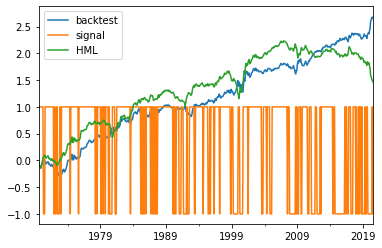

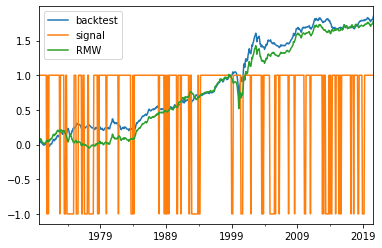

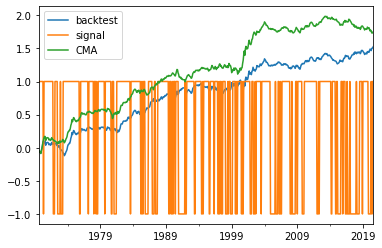

In [26]:
for var in factor_model.columns:
    plot_df = pd.concat([backtest[var].cumsum(), weights[var]], axis = 1)
    plot_df.columns = ['backtest', 'signal']
    plot_df.plot()
    returns.loc[weights.index, var].cumsum().plot(legend = True)

# Analyze the Market with New Factor

In [30]:
bt.check_new_factor(backtest, factor_model, index_symbol)

                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.001
Date:                Thu, 05 Nov 2020   Prob (F-statistic):              0.423
Time:                        12:44:03   Log-Likelihood:                 1023.1
No. Observations:                 612   AIC:                            -2032.
Df Residuals:                     605   BIC:                            -2001.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
portfolio      0.0100      0.133      0.075      0.9

# Simple Binary Decision

In [31]:
df_alpha_shift = df_alpha.shift(1).dropna(axis = 0)
backtest = returns.loc[df_alpha_shift.index]
weights = returns.loc[df_alpha_shift.index]
for count, row in  backtest.iterrows(): 
    for j in backtest.columns:
        if df_alpha_shift.loc[count, j] >= 0:
            backtest.loc[count, j] = backtest.loc[count, j]
            weights.loc[count, j] = 1.0
        else:
            backtest.loc[count, j] = -backtest.loc[count, j]
            weights.loc[count, j] = -1.0

<AxesSubplot:>

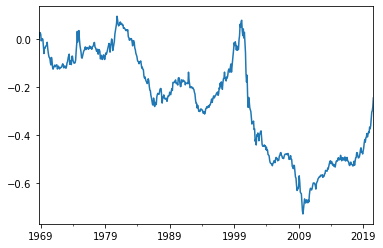

In [32]:
backtest.mean(axis = 1).cumsum().plot()

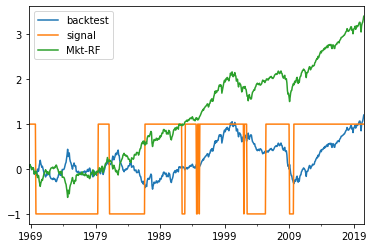

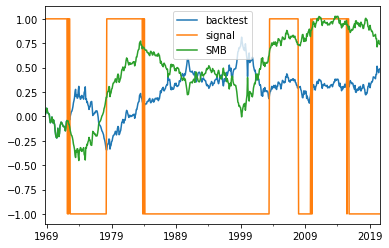

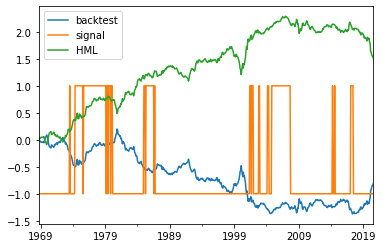

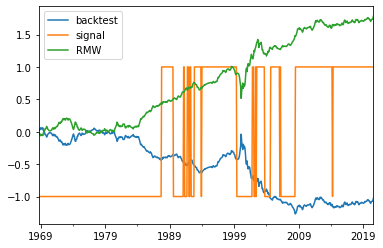

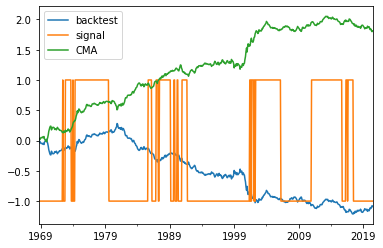

In [33]:
for var in factor_model.columns:
    plot_df = pd.concat([backtest[var].cumsum(), weights[var]], axis = 1)
    plot_df.columns = ['backtest', 'signal']
    plot_df.plot()
    returns.loc[weights.index, var].cumsum().plot(legend = True)

In [34]:
bt.factor_results(backtest, factor_model)

                            OLS Regression Results                            
Dep. Variable:              portfolio   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     48.16
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           4.29e-42
Time:                        12:44:08   Log-Likelihood:                 1808.9
No. Observations:                 624   AIC:                            -3606.
Df Residuals:                     618   BIC:                            -3579.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0328      0.013      2.450      0.0

In [35]:
bt.check_new_factor(backtest, factor_model, index_symbol)

                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.040
Date:                Thu, 05 Nov 2020   Prob (F-statistic):              0.398
Time:                        12:44:10   Log-Likelihood:                 1041.6
No. Observations:                 623   AIC:                            -2069.
Df Residuals:                     616   BIC:                            -2038.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
portfolio     -0.0932      0.138     -0.676      0.4